<a href="https://colab.research.google.com/github/mlaricobar/Research/blob/master/%5B05%5D_Tutorial_SR_Basado_en_Contenido_Hoteles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construcción de un Sistema de Recomendación Basado en Contenido para Hoteles en Seattle

¿Cómo usar la descripción de un hotel para recomendar hoteles similares?

El problema del Cold start es un problema muy investigado y conocido para los sistemas de recomendación, donde el sistema no es capaz de recomendar productos a usuarios. Esto es debido a diferentes razones: nuevos usuarios o nuevos productos.

El Filtrado Basado en Contenido es el método utilizado para resolver este tipo de problemas. En este enfoque se usan los metadatos de los nuevos productos cuando se tienen que crear recomendaciones, mientras que la acción del usuario pasa a un segundo plano por un cierto periodo de tiempo. Por lo que nuestros sistemas recomendarán un producto a un usuario basandose en su categoría o descripción.

La ventaja del Filtrado Basado en Contenido es que no tienen el problema de Cold-Start. Es decir, si recien tienes una página web en la que quieres recomendar productos, este enfoque te podría resultar muy útil en primera instancia.

### Entendimiento de los Datos

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# Importar los Módulos o Librerías de Python

# Módulo para tener acceso a Google Drive
from google.colab import drive
# Módulo para tratamiento de datos como tablas
import pandas as pd

# Módulo para contar palabras
from sklearn.feature_extraction.text import CountVectorizer

# Módulo para hacer gráficos
import matplotlib.pyplot as plt

# Módulo para hacer cálculos
import numpy as np

# Módulo para expresiones regulares
import re

# Stopwords en el Módulo NLTK
from nltk.corpus import stopwords

# Comando mágico para realizar ploteos en cada celda
%matplotlib inline

In [4]:
# Montar los ficheros de Google Drive a un directorio llamado 'gdrive'
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
!ls -l /gdrive/'My Drive'/Tesis/Notebooks/Data

total 156
-rw------- 1 root root 159321 Apr 16 21:12 Seattle_Hotels_CBF.csv


In [6]:
df = pd.read_csv('/gdrive/My Drive/Tesis/Notebooks/Data/Seattle_Hotels_CBF.csv', encoding="latin-1")
df.head()

,name,address,desc
0,Hilton Garden Seattle Downtown,"1821 Boren Avenue, Seattle Washington 98101 USA","Located on the southern tip of Lake Union, the..."
1,Sheraton Grand Seattle,"1400 6th Avenue, Seattle, Washington 98101 USA","Located in the city's vibrant core, the Sherat..."
2,Crowne Plaza Seattle Downtown,"1113 6th Ave, Seattle, WA 98101","Located in the heart of downtown Seattle, the ..."
3,Kimpton Hotel Monaco Seattle,"1101 4th Ave, Seattle, WA98101",What?s near our hotel downtown Seattle locatio...
4,The Westin Seattle,"1900 5th Avenue, Seattle, Washington 98101 USA",Situated amid incredible shopping and iconic a...


In [0]:
# Definimos una funcion para pintar un ejemplo de registro
def print_description(index):
    example = df.loc[df.index == index][['name', 'desc']].values[0]
    if len(example) > 0:
        print('Name:\n\n{0}\n'.format(example[0]))
        print("".join(["-"]*(len(example[0]) + 10)))
        print('\nDescription:\n\n{0}'.format(example[1]))
        

In [8]:
print_description(20)

Name:

Embassy Suites by Hilton Seattle Downtown Pioneer Square

------------------------------------------------------------------

Description:

Nestled in Seattle's original neighborhood Pioneer Square, the Embassy Suites by Hilton Downtown is the perfect hub for your next Northwest experience. Our spacious suites offer sleeping and living areas, a queen-size sofa bed as well as a 50-inch HDTV, kitchenettes and innovative technology. Dine at a Seattle institution, 13 Coins, or meet friends for a hand-crafted cocktail at Zephyr Bar  located right in our lobby. When it's time to unwind, stop by the Health Club, which includes a heated indoor pool, hot tub and sun deck. Begin every morning with a free made-to-order breakfast and end the day with drinks and snacks at the complimentary Evening Reception. Explore Pike Market, Pier 55 or the Seattle Art Museum all within one mile. Cheer on your team at the CenturyLink Field, home to Seahawks Football and Sounders FC. Enjoy a relaxing Mari

### EDA

In [9]:
# CountVectorizer convierte una lista de documentos de texto en una matriz de conteos de tokens (o palabras).
# Esta implementación produce una representación dispersa de los conteos usando el tipo scipy.sparse.csr_matrix.
# Una matriz donde las filas hacen referencia a las posiciones de los textos y las columnas a las de los tokens.
vec = CountVectorizer().fit(df['desc'])
bag_of_words = vec.transform(df['desc'])
type(bag_of_words)

scipy.sparse.csr.csr_matrix

In [10]:
# A continuación lo que haremos es sumar todas las cantidades de veces que aparecen los tokens en cada documento de texto.
# La suma es a nivel de columnas por eso el "axis = 0"
sum_words = bag_of_words.sum(axis=0)
sum_words

matrix([[ 1, 11, 11, ...,  2,  6,  2]], dtype=int64)

In [11]:
# Una vez que hemos calculado la cantidad de apariciones en total de los tokens, asociames estas cantidades a cada token
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
print("Existen {0} tokens.".format(len(words_freq)))
print("Ejemplo de token: {0}".format(words_freq[0]))

Existen 3200 tokens.
Ejemplo de token: ('located', 108)


In [12]:
# Encontremos al token que aparece más veces
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:1]

[('the', 1258)]

In [0]:
# Definamos una función en la que reciba como input un corpus y el número de tokens más usados a mostrar
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

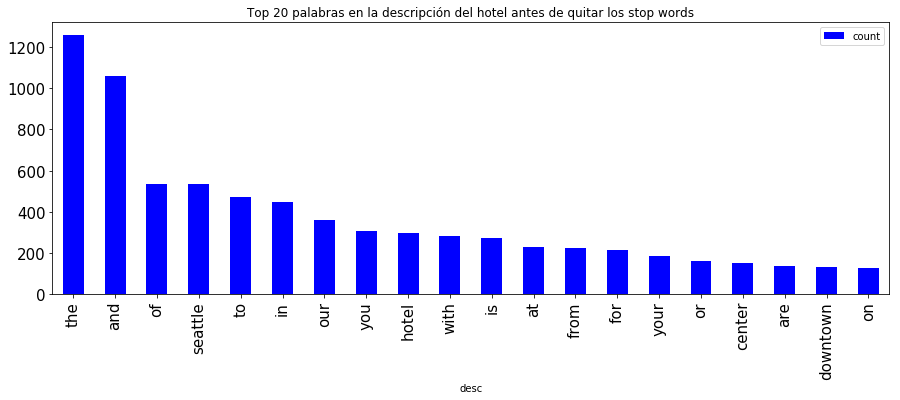

In [14]:
# Invocar a la función y plotear los resultados
common_words = get_top_n_words(df['desc'], 20)
df1 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
plot_1 = df1.plot(x="desc", y="count", kind="bar", figsize=(15, 5), grid=False, fontsize=15, title="Top 20 palabras en la descripción del hotel antes de quitar los stop words", colormap="winter")

In [0]:
# Definamos una función en la que reciba como input un corpus y el número de tokens más usados a mostrar despues de remover los stopwords
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

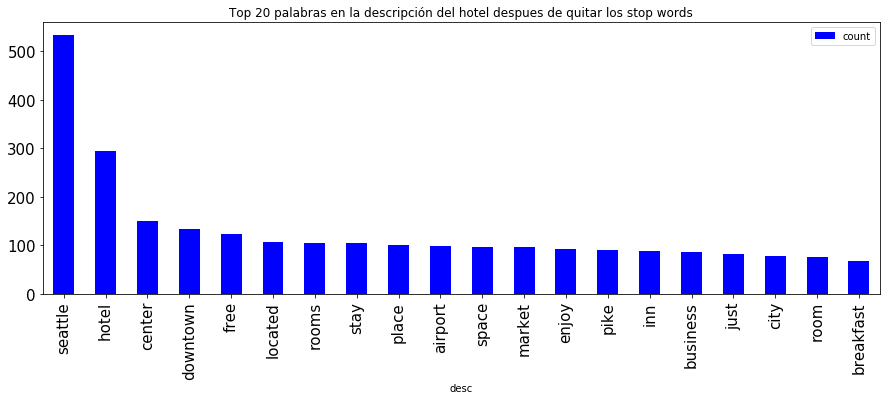

In [16]:
# Invocar a la función y plotear los resultados
common_words = get_top_n_words(df['desc'], 20)
df2 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
plot_2 = df2.plot(x="desc", y="count", kind="bar", figsize=(15, 5), grid=False, fontsize=15, title="Top 20 palabras en la descripción del hotel despues de quitar los stop words", colormap="winter")

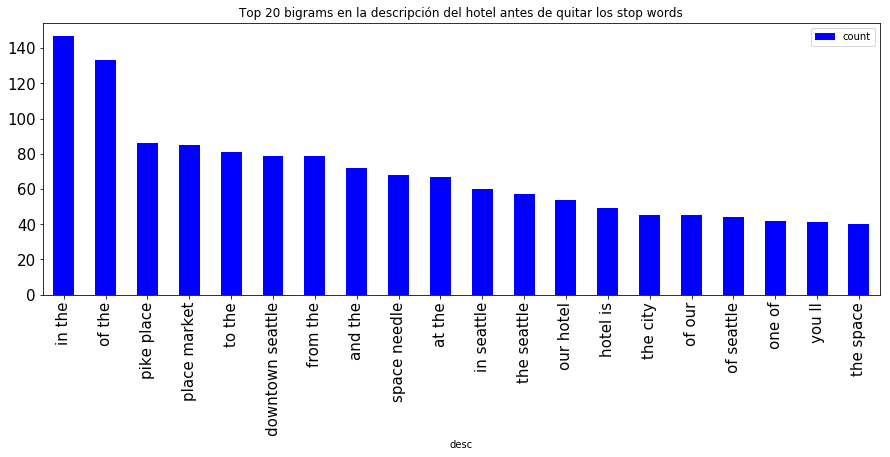

In [17]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['desc'], 20)
df3 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
plot_3 = df3.plot(x="desc", y="count", kind="bar", figsize=(15, 5), grid=False, fontsize=15, title="Top 20 bigrams en la descripción del hotel antes de quitar los stop words", colormap="winter")

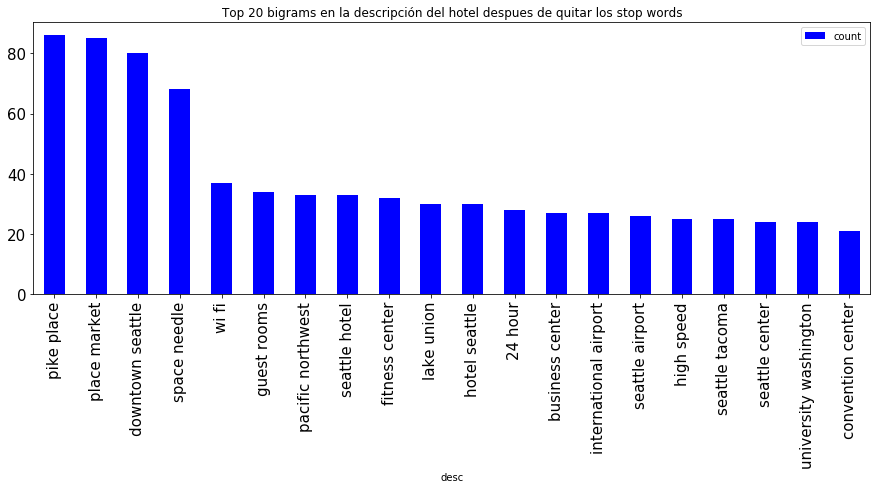

In [18]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['desc'], 20)
df4 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
plot_4 = df4.plot(x="desc", y="count", kind="bar", figsize=(15, 5), grid=False, fontsize=15, title="Top 20 bigrams en la descripción del hotel despues de quitar los stop words", colormap="winter")

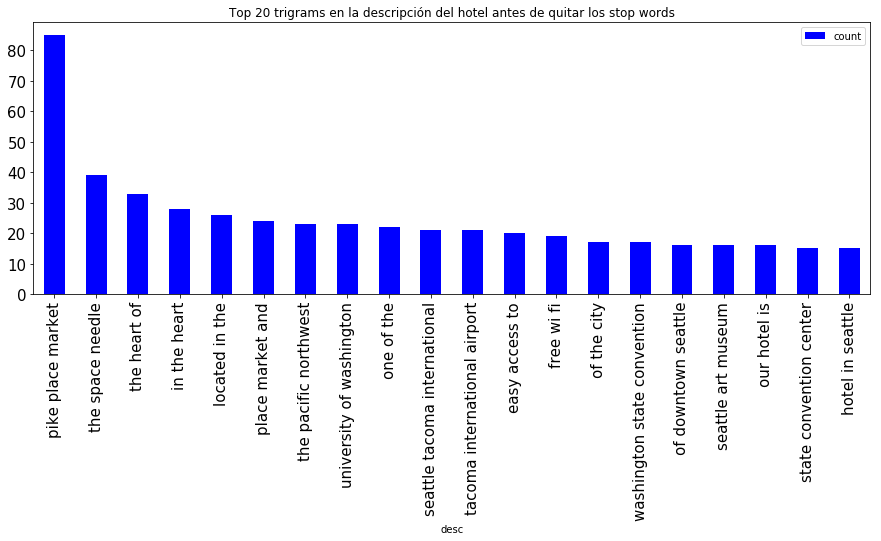

In [19]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['desc'], 20)
df5 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
plot_5 = df5.plot(x="desc", y="count", kind="bar", figsize=(15, 5), grid=False, fontsize=15, title="Top 20 trigrams en la descripción del hotel antes de quitar los stop words", colormap="winter")

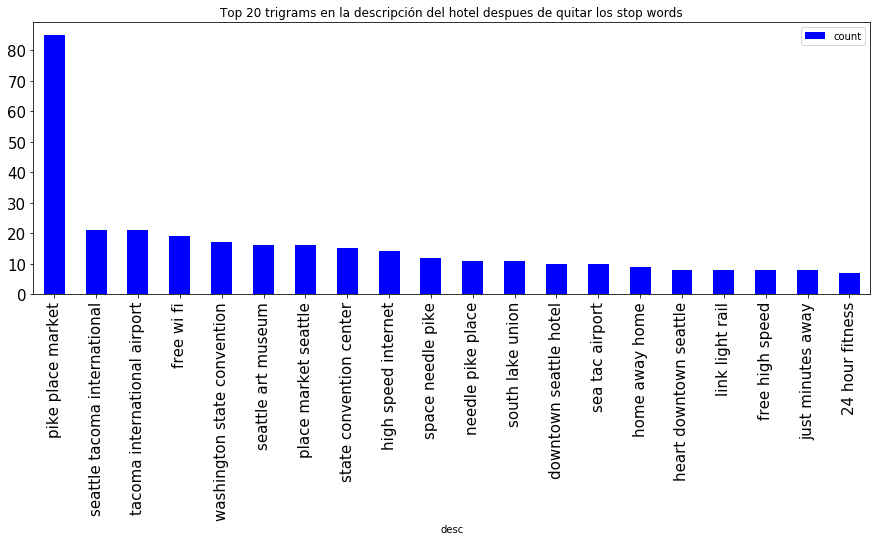

In [20]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['desc'], 20)
df6 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
plot_6 = df6.plot(x="desc", y="count", kind="bar", figsize=(15, 5), grid=False, fontsize=15, title="Top 20 trigrams en la descripción del hotel despues de quitar los stop words", colormap="winter")

In [0]:
#df

In [22]:
df['word_count'] = df['desc'].apply(lambda x: len(str(x).split()))
desc_lengths = list(df['word_count'])
print("Númweo de descripciones:",len(desc_lengths),
      "\nPromedio de cantidad de palabras: ", np.average(desc_lengths),
      "\nMínima cantidad de palabras: ", min(desc_lengths),
      "\nMáxima cantidad de palabras: ", max(desc_lengths))

Númweo de descripciones: 152 
Promedio de cantidad de palabras:  156.94736842105263 
Mínima cantidad de palabras:  16 
Máxima cantidad de palabras:  494


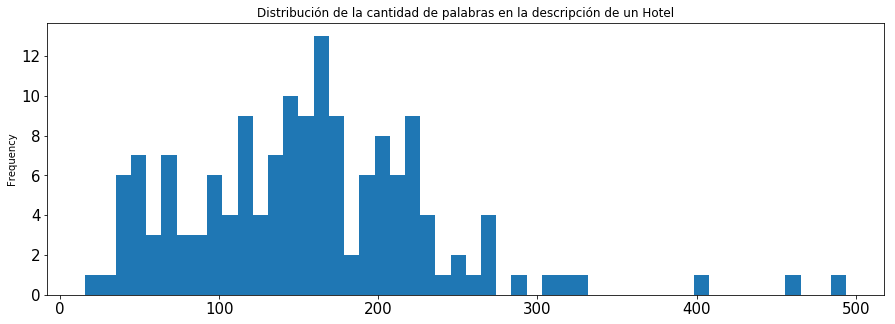

In [23]:
plot_7 = df['word_count'].plot(kind="hist", bins=50, figsize=(15, 5), grid=False, fontsize=15, title="Distribución de la cantidad de palabras en la descripción de un Hotel")

### Procesamiento de Texto

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [0]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
df['desc_clean'] = df['desc'].apply(clean_text)

In [0]:
# Definimos una funcion para pintar un ejemplo de registro
def print_description(index):
    example = df.loc[df.index == index][['name', 'desc_clean']].values[0]
    if len(example) > 0:
        print('Name:\n\n{0}\n'.format(example[0]))
        print("".join(["-"]*(len(example[0]) + 10)))
        print('\nDescription:\n\n{0}'.format(example[1]))

In [27]:
print_description(20)

Name:

Embassy Suites by Hilton Seattle Downtown Pioneer Square

------------------------------------------------------------------

Description:

nestled seattles original neighborhood pioneer square embassy suites hilton downtown perfect hub next northwest experience spacious suites offer sleeping living areas queensize sofa bed well 50inch hdtv kitchenettes innovative technology dine seattle institution 13 coins meet friends handcrafted cocktail zephyr bar located right lobby time unwind stop health club includes heated indoor pool hot tub sun deck begin every morning free madetoorder breakfast end day drinks snacks complimentary evening reception explore pike market pier 55 seattle art museum within one mile cheer team centurylink field home seahawks football sounders fc enjoy relaxing mariners baseball game tmobile park plan trip around seattle boat show take show wamu theater


In [0]:
df.set_index('name', inplace = True)

In [0]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['desc_clean'])
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [0]:
indices = pd.Series(df.index)

In [32]:
indices[:10]

0    Hilton Garden Seattle Downtown
1            Sheraton Grand Seattle
2     Crowne Plaza Seattle Downtown
3     Kimpton Hotel Monaco Seattle 
4                The Westin Seattle
5       The Paramount Hotel Seattle
6                    Hilton Seattle
7                     Motif Seattle
8                   Warwick Seattle
9        Four Seasons Hotel Seattle
Name: name, dtype: object

In [0]:
def recommendations(name, cosine_similarities = cosine_similarities):
    
    recommended_hotels = []
    
    # gettin the index of the hotel that matches the name
    idx = indices[indices == name].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar hotels except itself
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the names of the top 10 matching hotels
    for i in top_10_indexes:
        recommended_hotels.append(list(df.index)[i])
        
    return recommended_hotels

In [34]:
recommendations('Hilton Seattle Airport & Conference Center')

['Embassy Suites by Hilton Seattle Tacoma International Airport',
 'DoubleTree by Hilton Hotel Seattle Airport',
 'Seattle Airport Marriott',
 'Motel 6 Seattle Sea-Tac Airport South',
 'Econo Lodge SeaTac Airport North',
 'Four Points by Sheraton Downtown Seattle Center',
 'Knights Inn Tukwila',
 'Econo Lodge Renton-Bellevue',
 'Hampton Inn Seattle/Southcenter',
 'Radisson Hotel Seattle Airport']

In [35]:
recommendations("The Bacon Mansion Bed and Breakfast")

['11th Avenue Inn Bed and Breakfast',
 'Shafer Baillie Mansion Bed & Breakfast',
 'Chittenden House Bed and Breakfast',
 'Gaslight Inn',
 'Bed and Breakfast Inn Seattle',
 'Silver Cloud Hotel - Seattle Broadway',
 'Hyatt House Seattle',
 'Mozart Guest House',
 'Quality Inn & Suites Seattle Center',
 'MarQueen Hotel']

#### Referencias:


*   [Building a Content Based Recommender System for Hotels in Seattle](https://towardsdatascience.com/building-a-content-based-recommender-system-for-hotels-in-seattle-d724f0a32070)
*   [Seattle Hotels Recommender.ipynb](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Seattle%20Hotels%20Recommender.ipynb)

